# 滚动测试范例

这里做一个滚动测试的范例。

## 滚动测试

滚动测试：向后看一段时间，找出模型在过去一段时间的最优参数，利用这个参数，向前做一段时间的交易。

例如：向后看3个月（黄色格），向前交易2个月（绿色格）

1. 测试1、2、3月，找出这3个月的最优参数，用来执行4、5月的交易。
2. 测试3、4、5月，找出这3个月的最优参数，用来执行6、7月的交易。
3. 如此类推，最后把4、5、6、7 ...的交易结果组合起来，就是最终的滚动测试的结果。

![](images/rolling.png)

## 需求

1. 用单均线系统，进行滚动测试。
2. 最优参数（均线周期），由最高的夏普比率决定。
2. 向后和向前的时间是整月，数量由外部决定。


In [7]:
#| include: false
# 以下都是例行公事，直接拷贝即可

import pandas as pd
import numpy as np 

# 导入matplotlib.pyplot绘图库，其中plt.plot()是最常用的绘图函数之一
import matplotlib.pyplot as plt 

import seaborn as sns

sns.set() # 默认用seaborn的绘图样式

plt.rcParams["font.sans-serif"]=["Microsoft YaHei"] #设置字体。如果不设置，中文会乱码。这里采用微软雅黑'Microsoft YaHei'，如果显示不正常，也可以使用黑体'SimHei'或者宋体'SimSun'等
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 绘图使用'svg'后端：svg是矢量格式，可以任意缩放均保持清晰，各种屏幕的显示良好。
%config InlineBackend.figure_formats = ['svg']

In [8]:
import akshare as ak

计算移动平均和夏普比率的函数

In [9]:
def sma(x,period):
    return x.rolling(period).mean()

def sharpe_ratio(lrets, rf = 0.03):
    return (np.mean(lrets) * 250 - rf) / (np.std(lrets) * np.sqrt(250))

## 简单数据处理

In [10]:
# 读取宁德时代
# 见：https://akshare.xyz/data/stock/stock.html#id20

df = ak.stock_zh_a_hist(symbol="300750",start_date='20180101',end_date='20231212', adjust='qfq')

df

,日期,开盘,收盘,最高,最低,成交量,成交额,振幅,涨跌幅,涨跌额,换手率
0,2018-06-11,14.66,18.01,18.01,14.66,788,2.845471e+06,28.22,51.73,6.14,0.04
1,2018-06-12,20.02,20.02,20.02,20.02,266,1.058375e+06,0.00,11.16,2.01,0.01
2,2018-06-13,22.24,22.24,22.24,22.24,450,1.972314e+06,0.00,11.09,2.22,0.02
3,2018-06-14,24.67,24.67,24.67,24.67,743,3.578184e+06,0.00,10.93,2.43,0.03
4,2018-06-15,27.35,27.35,27.35,27.35,2565,1.359503e+07,0.00,10.86,2.68,0.12
...,...,...,...,...,...,...,...,...,...,...,...
1334,2023-12-06,158.65,162.88,166.86,158.22,367693,6.024340e+09,5.44,2.56,4.07,0.94
1335,2023-12-07,162.00,164.49,166.36,161.60,269084,4.410842e+09,2.92,0.99,1.61,0.69
1336,2023-12-08,165.00,163.59,166.33,163.12,245020,4.030383e+09,1.95,-0.55,-0.90,0.63
1337,2023-12-11,162.01,165.35,165.69,160.16,214896,3.497266e+09,3.38,1.08,1.76,0.55


In [11]:
df['日期'] = pd.to_datetime(df['日期'])
df.set_index('日期',inplace = True)
df = df[['涨跌幅']]/100
df.fillna(0,inplace=True)
df['price'] = (df['涨跌幅'] + 1).cumprod() # 用涨跌幅反算出复权价，上市日前一天为1。
df['lrets'] = np.log(df['涨跌幅'] + 1)
df.tail()

,涨跌幅,price,lrets
日期,,,
2023-12-06,0.0256,13.678666,0.025278
2023-12-07,0.0099,13.814085,0.009851
2023-12-08,-0.0055,13.738107,-0.005515
2023-12-11,0.0108,13.886479,0.010742
2023-12-12,-0.0104,13.742059,-0.010454


## 构造滚动窗口

需求：构造出回看月份，和测试月份的序列

例如：回看[4,5,6]月，交易[7,8]月；回看[6,7,8]月，交易[9,10]月，那么

```python
train_time = [[4,5,6],[6,7,8]]
test_time = [[7,8],[9,10]]
```

相同的索引i，就可以取出回看区间和交易区间。



In [12]:
# 获得所有月份

all_months = df.resample('M').last().index.strftime('%Y-%m')
all_months

Index(['2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11',
       '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
       '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
       '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05',
       '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11',
       '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05',
       '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11',
       '2021-12', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05',
       '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11',
       '2022-12', '2023-01', '2023-02', '2023-03', '2023-04', '2023-05',
       '2023-06', '2023-07', '2023-08', '2023-09', '2023-10', '2023-11',
       '2023-12'],
      dtype='object', name='日期')

In [29]:
train_time = [] # 回看的月份
test_time = [] # 前向交易的月份

# 回看周期
back_n = 2

# 前向交易周期
test_n = 1

# 遍历所有月份
# 把第0月到back_n-1月，放入train_time
# 把back_n月到back_n + test_n月，放入test_time
for i in range(0,len(all_months) - (back_n + test_n) + 1,test_n):
    train_time.append(all_months[i:(i+back_n)])
    test_time.append(all_months[i+back_n:(i+back_n+test_n)])

print(train_time[0])
print(test_time[0])
print(train_time[1])
print(test_time[1])

Index(['2018-06', '2018-07'], dtype='object', name='日期')
Index(['2018-08'], dtype='object', name='日期')
Index(['2018-07', '2018-08'], dtype='object', name='日期')
Index(['2018-09'], dtype='object', name='日期')


## 构造一个测试窗口的最优化函数

需求：给出测试的时间段，问哪个均线的夏普比率最高？

思路：

1. 暴力测试全部均线
2. 返回均线周期，和对应时间段的夏普比率


In [23]:
# 对于指定的起点和终点，找出最佳的均线

def get_best_ma(start, end):
    
    # 暴力优化，穷举60,70,...250的所有周期
    ma_period_list = range(60,250,10)

    result = []

    for ma_period in ma_period_list:
        
        # 单均线交易系统，很简单
        df['ma'] = sma(df.price, ma_period)
        df['pos'] = np.where(df.price > df.ma,1,0) # 只允许做多
        df['traded'] = df['lrets'] * df.pos.shift() 

        # 计算测试区间[start:end]的夏普比率
        result.append((ma_period, sharpe_ratio(df.loc[start:end].traded)))

    res = pd.DataFrame(result)
    res.columns = ['ma_period','sharpe']
    return res

get_best_ma('2021-05','2021-11').sort_values(['sharpe','ma_period'],ascending=False).head()

,ma_period,sharpe
18,240,2.026914
17,230,2.026914
16,220,2.026914
15,210,2.026914
14,200,2.026914


## 构造一个窗口测试函数

需求：对于一个测试窗口i，包括训练集（回看最优）和测试集（前向交易），计算前向交易的结果

In [16]:
def test_a_window(i):
    """测试一个窗口i。
    例如，寻找7月和8月的最佳均线，用来执行9月的交易，返回9月的交易结果。
    """

    # 前面算好的测试用窗口i，取起点和终点的时间
    start = train_time[i][0]
    end = train_time[i][-1]
    # 问，这段时间内，什么均线的参数最优？
    res = get_best_ma(train_time[i][0],train_time[i][-1]
                      ).sort_values(['sharpe','ma_period'],ascending=False).iloc[0]
    
    #print(f"在{start}到{end}之间，最佳的均线是{int(res['ma_period'])}，区间年化夏普比率是{round(res['sharpe'],4)}。")

    # 利用上述最优的参数，我们进行交易
    ma_period = int(res['ma_period'])
    df['ma'] = sma(df.price, ma_period)
    df['pos'] = np.where(df.price > df.ma,1,0) 
    df['traded'] = df['lrets'] * df.pos.shift() 
    #print(f"使用上述设置，在{list(test_time[i])}内的对数收益率是{round(df.loc[test_time[i][0]:test_time[i][-1]].traded.sum(),4)}")

    # 返回测试集对应时间段的持仓情况。
    return df['pos'].loc[test_time[i][0]:test_time[i][-1]]

test_a_window(4).head()

/tmp/ipykernel_75608/2749032695.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.mean(lrets) * 250 - rf) / (np.std(lrets) * np.sqrt(250))


日期
2018-12-03    1
2018-12-04    1
2018-12-05    1
2018-12-06    1
2018-12-07    1
Name: pos, dtype: int64

## 测试所有的窗口
最后把所有滚动交易的结果组合在一起

In [25]:
pos_final = []
for i in range(len(train_time)):
    pos_final.append(test_a_window(i))

pos_final = pd.concat(pos_final)

/tmp/ipykernel_75608/2749032695.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.mean(lrets) * 250 - rf) / (np.std(lrets) * np.sqrt(250))


## 结果

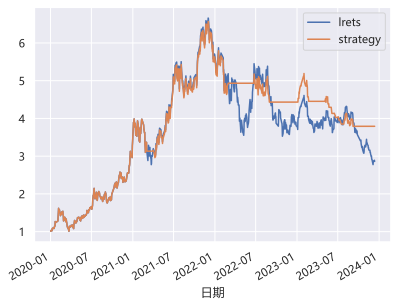

In [28]:
df.loc[:,'strategy'] = df.lrets * pos_final.shift() # 注意不要作弊
df[['lrets','strategy']].loc['2020':].cumsum().apply(np.exp).plot();

计算一些比率

In [19]:
df[['lrets','strategy']].loc['2020':].agg(sum)

lrets       1.051267
strategy    1.332854
dtype: float64

In [20]:
df[['lrets','strategy']].loc['2020':].agg(sharpe_ratio)

lrets       0.502773
strategy    0.773818
dtype: float64